
## Ames Housing Data and Kaggle Challenge

Part 3 - after the 02_Preprocessing_and_Feature_Engineering

This notebook is the last part.. intended for creating regresssion models and testing.
and using the final models to predict the test dataset for submission to Kaggle

In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#regression models
import sklearn  #to show version
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, KFold,cross_validate
from sklearn import preprocessing
from sklearn import metrics

#for OLS
import statsmodels.api as sm

%matplotlib inline

In [2]:
#package versions
#show versions of packages
print('pandas: ', pd.__version__)
print('seaborn: ', sns.__version__)
print('numpy: ', np.__version__)
print('sklearn', sklearn.__version__)

pandas:  1.3.4
seaborn:  0.11.1
numpy:  1.21.4
sklearn 0.24.1


In [3]:
import warnings
warnings.filterwarnings('ignore')

### USER DEFINED VARIABLES

In [4]:
#store the resutt of regression models
regression_dict = {}

#we will use the same alphas for different regression models
my_alphas = np.linspace(100, 800, 100)

#parameter for cross validation
crossval = KFold(n_splits=5, shuffle=True, random_state=52)

### USER DEFINED FUNCTIONS

In [5]:
def rmodel_crossval(model_type, alphas, X_train, y_train, X_val, y_val, dic):
    ''' this function is to use cross validation, loop and search the best alpha
    parameter: model_type ('Ridge' or 'Lasso' or 'Enet'), list of alpha,
    X_train, y_train, X_val, y_val, dic(dictionary of the regression result)
    
    return: optimal alpha based on the range of alpha, the rest of the result will be added in the dictionary
    '''
    
    val_score_list = []    #this is out X_val and y_val
    train_score_list = []  #this is our X_train and y_train
    cv_score_list = []     #this is our Cross validation from (X_train)
    mse_train_list = []     #this is our mean squared error for train
    mse_val_list = []     #this is our mean squared error for val
    rmse_train_list = []     #this is our root mean squared error
    rmse_val_list = []     #this is our root mean squared error
    
    #loop for each alpha
    for alpha in alphas:
###BEGIN LOOP        
        #print("Trying for alpha:",alpha )
        
        if model_type == 'Lasso':
            rmodel = Lasso(alpha = alpha)
        elif model_type == 'Ridge':
            rmodel = Ridge(alpha = alpha)
        elif model_type == 'Enet':
            rmodel = ElasticNet(alpha = alpha)
        else:
            print('Invalid Model Type, Lasso, Ridge')
            return None

        cv = cross_validate(
            rmodel, X_train, y_train, scoring='r2', cv=crossval, 
            return_train_score = True)
        
        train_score_list.append(np.mean(cv['train_score']))
        cv_score_list.append(np.mean(cv['test_score']))
            
        #fit  Train
        rmodel.fit(X_train,y_train)
        y_train_pred = rmodel.predict(X_train)
        mse_train_list.append(metrics.mean_squared_error(y_train, y_train_pred))
        rmse_train_list.append(metrics.mean_squared_error(y_train, y_train_pred, squared=False))
        
        #predict Val
        y_pred = rmodel.predict(X_val)
        mse_val_list.append(metrics.mean_squared_error(y_val, y_pred))
        rmse_val_list.append(metrics.mean_squared_error(y_val, y_pred, squared=False))
        
        val_score_list.append(rmodel.score(X_val, y_val))
###END LOOP
    
    
    #after looping, search the optimal alpha
    optimal_alpha_index = np.argmax(val_score_list)
    optimal_alpha = alphas[optimal_alpha_index]
    
    #maximum score in our validation data
    val_score = np.max(val_score_list)
    
    #train score using the same alpha
    train_score = train_score_list[optimal_alpha_index]
    
     #train mse using the same alpha
    mse_train_score = mse_train_list[optimal_alpha_index]
    mse_val_score = mse_val_list[optimal_alpha_index]
    
    #train rmse using the same alpha
    rmse_train_score = rmse_train_list[optimal_alpha_index]
    rmse_val_score = rmse_val_list[optimal_alpha_index]
    
    #lets plot the results
    rmodel_plot(
            cv_score_list, train_score_list, val_score_list,alphas, optimal_alpha,
        model_type)
    
    
    
    print('Alpha:', optimal_alpha)
    print('R2 of Train:', train_score, ', R2 of Val:', val_score)
    print('MSE of Train,', mse_train_score, ', MSE of Val', mse_val_score)
    print('RMSE of Train,', rmse_train_score, ', RMSE of Val', rmse_val_score)

    model_print = model_type + '(cross_validate)'
    
    dic[model_print] = {'alpha': optimal_alpha, 
                                   'train_score': round(train_score,4), 
                                   'validation_score' : round(val_score,4),
                                   'mse_train': round(mse_train_score,4), 
                                   'mse_val':round(mse_val_score,4), 
                                   'rmse_train': round(rmse_train_score,4),
                                   'rmse_val': round(rmse_val_score,4)}
    
    return optimal_alpha

In [6]:
def rmodel_plot(cross_val_score, train_score_list, val_score_list, alphas, optimal_alpha,
    model_type):
    
    '''plotting the optimal alpha and the r2 score of cross validation, train data, and validation data
    parameters: cross_val_score, train_score_list, alphas, optimal_alpha,
                model_type, val_score_list
    return: no return, just plot the graph
    '''
    
    #set figure size
    plt.figure(figsize = (7,5))
    
    #cross validation score
    sns.lineplot(y = cross_val_score, x = alphas, 
                 label = 'CrossVal from X_train')
    
    #training data score
    sns.lineplot(y = train_score_list, x = alphas, 
                 label = 'Training Data (X_train)')
    
    #vertical line for the optimal alpha
    plt.axvline(x=optimal_alpha, linestyle='--')
    
    
    #
    sns.lineplot(y = val_score_list, x = alphas, 
                     label = 'Validation Data (X_val)')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.title(model_type)
    plt.xlabel('alphas')
    plt.ylabel('r2 (score)')
    
    plt.legend()
    plt.show()

In [7]:
def get_r2_mse(model, model_name, alpha, x_train, x_val, y_train, y_val, reg_dict, add_dic=False):
    '''to help in getting r2, mse and rmse in different models
    parameter: model, x_train, x_val, y_train, y_val, 
    reg_dict (dictionary to add the result), 
    add_dic (if we want to add the result in dictionary)'''
    
    #fit the model
    model.fit(x_train, y_train)
    
    #r2
    train_score = model.score(x_train, y_train)
    val_score = model.score(x_val, y_val)

    #predict train and validation
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)

    #mean square error for train
    mse_train = metrics.mean_squared_error(y_pred_train, y_train)
    rmse_train = metrics.mean_squared_error(y_pred_train, y_train, squared=False)

    #mean square error for val
    mse_val = metrics.mean_squared_error(y_pred_val, y_val)
    rmse_val = metrics.mean_squared_error(y_pred_val, y_val, squared=False)
    
    print('Alpha:', alpha)
    print('R2 of Train:', train_score, ', R2 of Val:', val_score)
    print('MSE of Train,', mse_train, ', MSE of Val', mse_val)
    print('RMSE of Train,', rmse_train, ', RMSE of Val', rmse_val)

    if add_dic:
        regression_dict[model_name] = {'alpha': round(alpha,4), 
                                   'train_score': round(train_score,4), 
                                   'validation_score' : round(val_score,4),
                                   'mse_train': round(mse_train,4), 
                                   'mse_val':round(mse_val,4), 
                                   'rmse_train': round(rmse_train,4),
                                   'rmse_val': round(rmse_val,4)}

## Loading of train dataset with additional features

In [8]:
df_train = pd.read_csv("../datasets/train_wfeature_all.csv")
df_train.head()

,Unnamed: 0,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,...,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,HouseAge,Remodel_Age,is_Remodeled,Total_SF
0,0,109,533352170,60,6.0,79.0,13517,2,3,2.0,...,0,0,3,2010,6.0,130500,34,29,0,2204.0
1,1,544,531379050,60,6.0,43.0,11492,2,3,2.0,...,0,0,4,2009,6.0,220000,13,1,1,3035.0
2,2,153,535304180,20,6.0,68.0,7922,2,4,2.0,...,0,0,1,2010,6.0,109000,57,54,0,2114.0
3,3,318,916386060,60,6.0,73.0,9802,2,4,2.0,...,0,0,4,2010,6.0,174000,4,1,1,1828.0
4,4,255,906425045,50,6.0,82.0,14235,2,3,2.0,...,0,0,3,2010,6.0,138500,110,93,0,2121.0


In [9]:
#drop unnecessary columns
df_train.drop(columns=['Unnamed: 0', 'Id', 'PID'], inplace=True)

In [10]:
#check the number of data points and columns
df_train.shape

(1955, 79)

In [11]:
#check that there is no null values
df_train.isnull().sum()[df_train.isnull().sum()>0].sort_values()

Series([], dtype: int64)

In [12]:
df_train.dtypes

MS SubClass       int64
MS Zoning       float64
Lot Frontage    float64
Lot Area          int64
Street            int64
                 ...   
SalePrice         int64
HouseAge          int64
Remodel_Age       int64
is_Remodeled      int64
Total_SF        float64
Length: 79, dtype: object

***define X  and y***

In [13]:
X=df_train.drop(columns=['SalePrice'])
y=df_train['SalePrice']

In [14]:
#check the p-value using the OLS from statsmodel.api
ols = sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              2523.
Date:                Wed, 02 Feb 2022   Prob (F-statistic):                        0.00
Time:                        20:24:02   Log-Likelihood:                         -21944.
No. Observations:                1955   AIC:                                  4.403e+04
Df Residuals:                    1882   BIC:                                  4.444e+04
Df Model:                          73                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
MS SubClass       -87.9702     13.651     -6.444      0.000    -114.743     -61.198
MS Zoning          83.2589    687.098      0.121      0.904   -1264.295    1430.813
Lot Frontage        4.3310     29.784      0.145      0.884     -54.083      62.745
Lot Area            0.4724      0.109      4.324      0.000       0.258       0.687
Street           3971.6334   7334.510      0.541      0.588   -1.04e+04    1.84e+04
Lot Shape        -331.3108    881.545     -0.376      0.707   -2060.219    1397.598
Land Contour     1929.5686   1062.026      1.817      0.069    -153.303    4012.440
Utilities        1.357e+04   8649.531      1.569      0.117   -3389.448    3.05e+04
Lot Config        370.3655    398.199      0.930      0.352    -410.593    1151.324
Land Slope      -3142.3434   2022.216     -1.554      0.120   -7108.365     823.678
Neighborhood     1089.4708    114.326      9.530      0.000     865.253    1313.689
Condition 1      2657.4013    398.318      6.672      0.000    1876.209    3438.593
Condition 2      1461.7162   1645.512      0.888      0.374   -1765.504    4688.937
Bldg Type        -494.7177    777.907     -0.636      0.525   -2020.369    1030.934
House Style      -855.3321    342.155     -2.500      0.013   -1526.375    -184.289
Overall Qual     8360.9329    601.215     13.907      0.000    7181.815    9540.050
Overall Cond     4683.5433    532.658      8.793      0.000    3638.880    5728.207
Year Built         31.2147     16.686      1.871      0.062      -1.510      63.940
Year Remod/Add     47.7147     19.784      2.412      0.016       8.914      86.515
Roof Style       2288.7173   1004.441      2.279      0.023     318.783    4258.651
Roof Matl        -634.4095   1958.209     -0.324      0.746   -4474.899    3206.080
Exterior 1st      494.2178    305.150      1.620      0.105    -104.250    1092.685
Exterior 2nd     -125.4053    253.542     -0.495      0.621    -622.659     371.848
Mas Vnr Type      845.2049    645.693      1.309      0.191    -421.144    2111.554
Mas Vnr Area        1.9953      3.564      0.560      0.576      -4.995       8.986
Exter Qual       7528.1079   1355.277      5.555      0.000    4870.104    1.02e+04
Exter Cond      -1333.5862   1284.736     -1.038      0.299   -3853.243    1186.071
Foundation        844.8569    490.271      1.723      0.085    -116.675    1806.389
Bsmt Qual         986.7543   1003.339      0.983      0.326    -981.019    2954.527
Bsmt Cond       -3149.2287   1189.463     -2.648      0.008   -5482.034    -816.424
Bsmt Exposure    1413.3384    360.424      3.921      0.000     706.465    2120.211
BsmtFin Type 1    122.8675    330.985      0.371      0.711    -526.268     772.003
BsmtFin SF 1        9.3018      1.684      5

***below 0.05 p-value, means they are statistically significant ...***
- MS SubClass,Lot Area,Neighborhood,Condition 1,House Style,
Overall Qual, Overall Cond, Year Remod/Add, Roof Style, Exter Qual,
Bsmt Cond,Bsmt Exposure,BsmtFin SF 1,Total Bsmt SF,Heating QC,	
Electrical,1st Flr SF,nd Flr SF,2nd Flr SF,Bsmt Full Bath,Bedroom AbvGr,
Kitchen AbvGr,Kitchen Qual,Functional,Fireplace Qu,Garage Area,Open Porch SF,
Screen Porch,Yr Sold,HouseAge

### split train datasets into train and validation, 80% train and 20% validation data

In [15]:
#split the data as train and validation
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=52)

In [16]:
#scale the X
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

### Create polynomial features from train and val datasets

In [17]:
poly = PolynomialFeatures(
    degree = 2, include_bias = False, interaction_only = False)

In [18]:
X_train_poly = poly.fit_transform(X_train)
polynomial_column_names = poly.get_feature_names(input_features = X_train.columns)
X_train_poly = pd.DataFrame(data = X_train_poly, columns = polynomial_column_names )

In [19]:
X_val_poly = poly.fit_transform(X_val)
polynomial_column_names = poly.get_feature_names(input_features = X_val.columns)
X_val_poly = pd.DataFrame(data = X_val_poly, columns = polynomial_column_names )

In [20]:
#check how many features we have after poly
X_train_poly.shape

(1564, 3159)

In [21]:
#scale the X - Poly
ssp = StandardScaler()
X_train_scaled_poly = ssp.fit_transform(X_train_poly)
X_val_scaled_poly = ssp.transform(X_val_poly)

## Linear Regression (without Poly)

In [22]:
# Instantiate model.
lr = LinearRegression()
get_r2_mse(lr, 'LR (no poly)', 0, X_train_scaled, X_val_scaled, y_train, y_val, regression_dict, True)

Alpha: 0
R2 of Train: 0.9065599249800954 , R2 of Val: 0.9040406489205822
MSE of Train, 330990756.00769347 , MSE of Val 357044247.6708944
RMSE of Train, 18193.151349002004 , RMSE of Val 18895.614508951392


## Linear Regression (with Poly)

In [23]:
# Instantiate model.
lrPoly = LinearRegression()

#we will not add this to our dictionary as the result is not good
get_r2_mse(lrPoly, 'LR (with poly)', 0, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, False)


Alpha: 0
R2 of Train: 1.0 , R2 of Val: -1.8991535518285003
MSE of Train, 9.67650384785196e-19 , MSE of Val 10787131083.6431
RMSE of Train, 9.83692220557424e-10 , RMSE of Val 103861.11439630859


***It's overfitting, the train dataset has 100% r2, but the validation score is negative 1.89!
MSE of validation is 10B!!! LR is not a good model for polynomials.***

### Searching for optimal alpha -> RIDGE, LASSO and ELASTiCNET

## Ridge

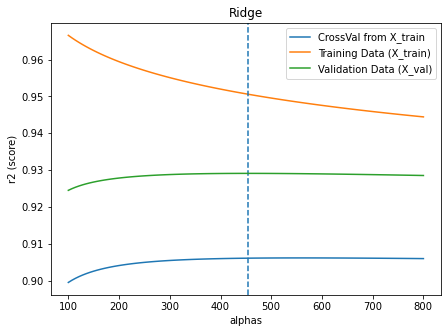

Alpha: 453.5353535353535
R2 of Train: 0.9506109350341434 , R2 of Val: 0.9291034292450665
MSE of Train, 180146972.6135066 , MSE of Val 263790995.69662446
RMSE of Train, 13421.88409328238 , RMSE of Val 16241.643872977404


In [24]:
#using cross validation to loop  with range of alphas and plot the optimal/chosen alpha

ridgesearch_optimal_alpha = rmodel_crossval('Ridge', my_alphas, X_train_scaled_poly, y_train, 
        X_val_scaled_poly, y_val,regression_dict)



In [25]:
#Using RidgeCV using the same alphas
ridge_cv = RidgeCV(alphas=my_alphas, cv=crossval)
ridge_cv.fit(X_train_scaled_poly, y_train);

#chosen alpha
ridge_cv_alpha = ridge_cv.alpha_

#get our result, but need to create a model again based on the chosen alpha
ridge = Ridge(alpha=ridge_cv_alpha)
get_r2_mse(ridge, 'RidgeCV', ridge_cv_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)

Alpha: 559.5959595959596
R2 of Train: 0.9469874973967146 , R2 of Val: 0.9290227965112458
MSE of Train, 187785040.95575103 , MSE of Val 264091012.87536567
RMSE of Train, 13703.468209024715 , RMSE of Val 16250.87729556056


In [26]:
#Using RandomizedSearchCV, search for the best alpa

param_grid = {'alpha': my_alphas}

# Instantiate model.
ridge_model = Ridge()
rand_search_ridge = RandomizedSearchCV(estimator=ridge_model, 
                                 param_distributions=param_grid,
                                 cv=crossval,
                                 n_iter=100)

rand_search_ridge.fit(X_train_scaled_poly, y_train);

#check the optimal alpha based on RandomizedSearchCV
ridgerandomscv_optimal_alpa = rand_search_ridge.best_estimator_.alpha

#get our result, but need to create a model again based on the chosen alpha
ridge = Ridge(alpha=ridgerandomscv_optimal_alpa)
get_r2_mse(ridge, 'Ridge RandomCSV', ridgerandomscv_optimal_alpa, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)




Alpha: 559.5959595959596
R2 of Train: 0.9469874973967146 , R2 of Val: 0.9290227965112458
MSE of Train, 187785040.95575103 , MSE of Val 264091012.87536567
RMSE of Train, 13703.468209024715 , RMSE of Val 16250.87729556056


## LASSO

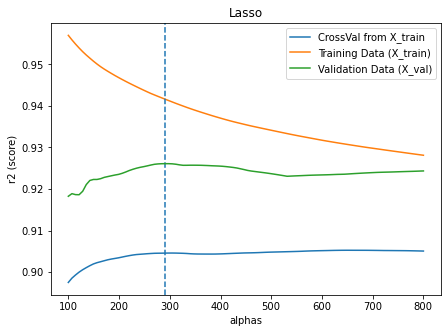

Alpha: 290.9090909090909
R2 of Train: 0.9416136410735498 , R2 of Val: 0.9260899887546477
MSE of Train, 219837472.32971793 , MSE of Val 275003364.06614524
RMSE of Train, 14826.917155286123 , RMSE of Val 16583.225381877473


In [27]:
#using cross validation to loop  with range of alphas and plot the optimal/chosen alpha
lassosearch_optimal_alpha = rmodel_crossval('Lasso', my_alphas, X_train_scaled_poly, y_train, 
        X_val_scaled_poly, y_val,regression_dict)


In [28]:
#Using LassoCV using the same alphas
lasso_cv = LassoCV(alphas=my_alphas,cv=crossval)

#instantiate the model
lasso_cv.fit(X_train_scaled_poly, y_train);

#get the optimal alpha
lasso_cv_alpha = lasso_cv.alpha_

#get our result, but need to create a model again based on the chosen alpha
lasso = Lasso(alpha=ridgerandomscv_optimal_alpa)
get_r2_mse(lasso, 'LassoCV', lasso_cv_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)


Alpha: 679.7979797979798
R2 of Train: 0.9292541606120929 , R2 of Val: 0.9232116393423625
MSE of Train, 250601456.15694463 , MSE of Val 285713087.39048064
RMSE of Train, 15830.396588744852 , RMSE of Val 16903.04964763698


In [29]:
#do we have any features that zeroed out?
coef = dict(zip(polynomial_column_names, lasso_cv.coef_))

#uncomment if you want to see, but it's quite long
#coef 

## Lasso's coef_
<details>
  <summary>Out of 3159, there are only 30+ Features with coef_, the rest are 0s, expand for details</summary>

        #'MS SubClass Mas Vnr Type': -654.1489403181133,
        #'MS SubClass Mas Vnr Type': -654.1489403181133,
        #'MS SubClass Garage Area': -703.1880977250123,
        #'MS Zoning Condition 1': 732.1944822395341,
        #'MS Zoning Bldg Type': 494.2327493717202,
        #'MS Zoning Functional': 68.22189615343186,
        #'MS Zoning Sale Type': 782.327760433673,
        #'Lot Area Land Contour': 201.0705489834723,
        #'Lot Area Overall Cond': 808.4102640940354,
        #'Lot Area Exterior 1st': 2079.293074914176,
        #'Lot Area Mas Vnr Type': 671.0863274559588,
        #'Lot Area Paved Drive': 1869.3584761342483,
        #'Street Functional': 497.97823447403516,
        #'Lot Shape Kitchen AbvGr': -254.398620531571,
        #'Land Contour Overall Qual': 146.53163425696454,
        #'Utilities Year Remod/Add': 336.4946940202968,
        #'Lot Config Mas Vnr Area': -299.9970301720546,
        #'Land Slope Roof Matl': -241.75796536619774,
        #'Land Slope Kitchen AbvGr': -282.65870164953304,
        #'Neighborhood^2': 1289.2993556183199,
        #'Neighborhood Overall Qual': 2736.0926437310322,
        #'Neighborhood Low Qual Fin SF': -407.32079988508303,
        #'Neighborhood Gr Liv Area': 3116.667530950304,
        #'Neighborhood Fireplace Qu': 1841.1185391045533,
        #'Neighborhood Garage Finish': 369.751068284764,
        #'Condition 1 Overall Qual': 424.15707182282625,
        #'Condition 1 Overall Cond': 633.6837530095626
        #'Condition 1 Functional': 253.53255115924145,
        #'Condition 1 Paved Drive': 223.46153493956672
    
</details>

In [30]:
#Using RandomizedSearchCV, search for the best alpa
param_grid = {'alpha': my_alphas}

model = Lasso()
lasso_rand_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid,
                                 cv=crossval,
                                 n_iter=100)

lasso_rand_search.fit(X_train_scaled_poly, y_train);

#check the optimal alpha based on RandomizedSearchCV
lassorandomcsv_optimal_alpha = lasso_rand_search.best_estimator_.alpha


#get our result, but need to create a model again based on the chosen alpha
lasso = Lasso(alpha=lassorandomcsv_optimal_alpha)
get_r2_mse(lasso, 'LassoCV', lassorandomcsv_optimal_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)



Alpha: 651.5151515151515
R2 of Train: 0.9275816858953299 , R2 of Val: 0.9236080242703574
MSE of Train, 256525827.1592924 , MSE of Val 284238223.7444469
RMSE of Train, 16016.423669449194 , RMSE of Val 16859.366054049806


## ElasticNet

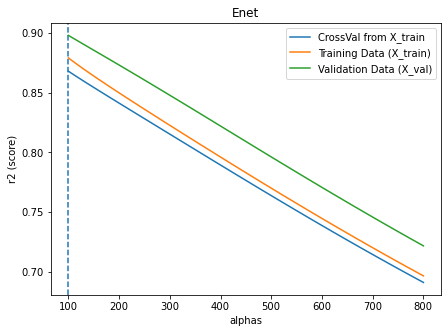

Alpha: 100.0
R2 of Train: 0.8792504008939034 , R2 of Val: 0.898089775028289
MSE of Train, 432157365.31005716 , MSE of Val 379186178.2691925
RMSE of Train, 20788.394967145905 , RMSE of Val 19472.70341450289


In [31]:
#using cross validation to loop  with range of alphas and plot the optimal/chosen alpha
enetsearch_optimal_alpha = rmodel_crossval('Enet', my_alphas, X_train_scaled_poly, y_train, 
        X_val_scaled_poly, y_val,regression_dict)


In [32]:
#using ElasticNetCV

# Instantiate model.
enetcv_model = ElasticNetCV(alphas=my_alphas, cv=crossval)

# Fit model 
enetcv_model.fit(X_train_scaled_poly, y_train)

#get the optimal alpha
enetcv_alpha = enetcv_model.alpha_

#get our result, but need to create a model again based on the chosen alpha
enet = ElasticNet(alpha=enetcv_alpha)
get_r2_mse(enet, 'ENetCV', enetcv_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)


Alpha: 100.0
R2 of Train: 0.8780001679743664 , R2 of Val: 0.898089775028289
MSE of Train, 432157365.31005716 , MSE of Val 379186178.2691925
RMSE of Train, 20788.394967145905 , RMSE of Val 19472.70341450289


In [33]:
#Using RandomizedSearchCV, search for the best alpa
param_grid = {'alpha': my_alphas}

model = ElasticNet()
enet_rand_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid,
                                 cv=crossval,
                                 n_iter=100)

enet_rand_search.fit(X_train_scaled_poly, y_train);

#check the optimal alpha based on RandomizedSearchCV
enetrandomcsv_optimal_alpha = enet_rand_search.best_estimator_.alpha

#get our result, but need to create a model again based on the chosen alpha
enet = ElasticNet(alpha=enetrandomcsv_optimal_alpha)
get_r2_mse(enet, 'ENet RandomSCV', enetrandomcsv_optimal_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)


Alpha: 100.0
R2 of Train: 0.8780001679743664 , R2 of Val: 0.898089775028289
MSE of Train, 432157365.31005716 , MSE of Val 379186178.2691925
RMSE of Train, 20788.394967145905 , RMSE of Val 19472.70341450289


***Optimal alpha for ElasticNet is 100 for all***

# Summmary of Regression Models

In [116]:
df_reg = pd.DataFrame(regression_dict).T.reset_index()
df_reg.rename(columns={"index":"model_type"}, inplace=True)

In [117]:
#Ridge with cross validation has the highest score and lowest rmse, with alpha = 453.535354
df_reg.sort_values(by='validation_score', ascending=False)

,model_type,alpha,train_score,validation_score,mse_train,mse_val,rmse_train,rmse_val
1,Ridge(cross_validate),453.535354,0.9506,0.9291,1.801470e+08,2.637910e+08,13421.8841,16241.6439
2,RidgeCV,559.596000,0.9470,0.9290,1.877850e+08,2.640910e+08,13703.4682,16250.8773
3,Ridge RandomCSV,559.596000,0.9470,0.9290,1.877850e+08,2.640910e+08,13703.4682,16250.8773
4,Lasso(cross_validate),290.909091,0.9416,0.9261,2.198375e+08,2.750034e+08,14826.9172,16583.2254
5,LassoCV,651.515200,0.9276,0.9236,2.565258e+08,2.842382e+08,16016.4237,16859.3661
0,LR (no poly),0.000000,0.9066,0.9040,3.309908e+08,3.570442e+08,18193.1513,18895.6145
6,Enet(cross_validate),100.000000,0.8793,0.8981,4.321574e+08,3.791862e+08,20788.3950,19472.7034
7,ENetCV,100.000000,0.8780,0.8981,4.321574e+08,3.791862e+08,20788.3950,19472.7034
8,ENet RandomSCV,100.000000,0.8780,0.8981,4.321574e+08,3.791862e+08,20788.3950,19472.7034


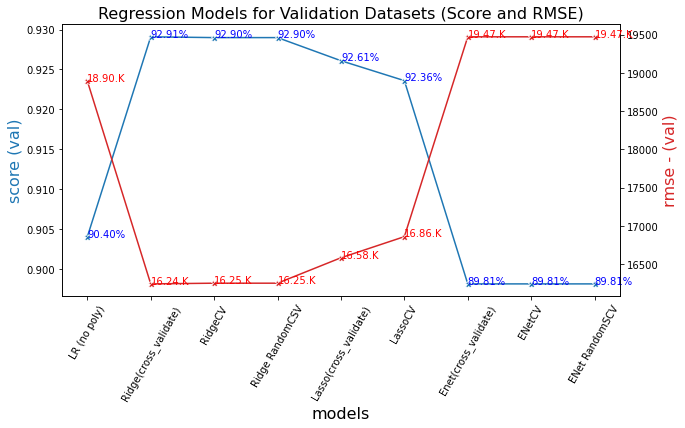

In [148]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,5))
color = 'tab:blue'

#line plot creation
ax1.set_title('Regression Models for Validation Datasets (Score and RMSE)', fontsize=16)

ax1.set_xlabel('models', fontsize=16)
ax1.set_ylabel('score (val)', fontsize=16,color=color)
ax1 = sns.lineplot(x='model_type', y='validation_score', data = df_reg, color=color,marker='X', dashes=False)

ax1.tick_params(axis='x', rotation=60)

# label points for score
for x, y in zip(df_reg['model_type'], df_reg['validation_score']):
    ax1.text(x = x, # x-coordinate position of data label
    y = y, # y-coordinate position of data label
    s = '{:.2f}%'.format(y*100), # data label, formatted to show percentage
    color = 'blue') # set colour of line
    
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

#line plot creation
ax2.set_ylabel('rmse - (val)', fontsize=16,color=color)
ax2 = sns.lineplot(x='model_type', y='rmse_val', data = df_reg, sort=False, color=color,marker='X')

# label points for rmse
for x, y in zip(df_reg['model_type'], df_reg['rmse_val']):
    ax2.text(x = x, # x-coordinate position of data label
    y = y, # y-coordinate position of data label
    s = '{:.2f}.K'.format(y/1000), # data label, formatted to show percentage
    color = 'red') # set colour of line


#show plot
plt.show()

# Summary and Conclusion
- LR with polynomials have 100% score in the train dataset but perform poorly in validation dataset (this was excluded in the summary as it skew the whole graph)
- LR has Elactic Net have higher RMSE
- Ridge with alpha of 453.53 have the highest score (r2) and lowest root mean squared error (rmse)*

## Let's get the best alpha for each model to prepare for the Test dataset


In [38]:
#ridge
ridge_final = Ridge(alpha=453.535354)
ridge_final.fit(X_train_scaled_poly, y_train)

Ridge(alpha=453.535354)

In [39]:
#lasso
lasso_final = Lasso(alpha=290.90909)
lasso_final.fit(X_train_scaled_poly, y_train)

Lasso(alpha=290.90909)

In [40]:
#enet
enet_final = ElasticNet(alpha=100)
enet_final.fit(X_train_scaled_poly, y_train)

ElasticNet(alpha=100)

## PREDICT Test Dataset (Kaggle submission)

In [41]:
df_test = pd.read_csv("../datasets/test_wfeature_all.csv")

In [42]:
df_test.head()

,Unnamed: 0,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,HouseAge,Remodel_Age,is_Remodeled,Total_SF
0,0,2658,902301120,190,4.0,69.0,9142,2,4,2.0,...,0,0,0,4,2006,6.0,96,40,0,2948
1,1,2718,905108090,90,6.0,69.0,9662,2,3,2.0,...,0,0,0,8,2006,6.0,29,0,0,3934
2,2,2414,528218130,60,6.0,58.0,17104,2,3,2.0,...,0,0,0,9,2006,8.0,0,0,0,2150
3,3,1989,902207150,30,4.0,60.0,8520,2,4,2.0,...,0,0,0,7,2007,6.0,84,83,0,1936
4,4,625,535105100,20,6.0,68.0,9500,2,3,2.0,...,185,0,0,7,2009,6.0,46,0,0,2788


In [43]:
df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [44]:
df_test.shape

(878, 80)

In [45]:
#check for NUll values
df_test.isnull().sum()[df_test.isnull().sum()>0].sort_values()

Series([], dtype: int64)

In [46]:
## Define X 
X_test = df_test.drop(columns=['Id', 'PID'])
X_test_scaled = ss.transform(X_test)

In [47]:
## Poly
X_test_poly = poly.fit_transform(X_test)
polynomial_column_names = poly.get_feature_names(input_features = X_test.columns)
X_test_poly = pd.DataFrame(data = X_test_poly, columns = polynomial_column_names )

In [48]:
# scale the X
X_test_poly_scaled = ssp.transform(X_test_poly)

### LR - PREDICT

In [150]:
df_test_lr = df_test.copy()

In [151]:
df_test_lr['SalePrice'] = lr.predict(X_test_scaled)

In [152]:
df_test_submit = df_test_lr[['Id','SalePrice']]

<AxesSubplot:>

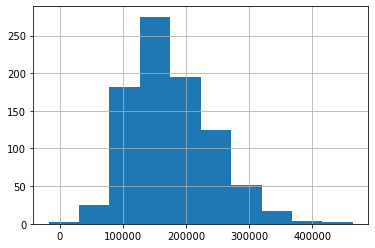

In [153]:
df_test_submit["SalePrice"].hist()

In [154]:
df_test_submit.to_csv("../datasets/submit_lreg.csv", index=False)

### RIDGE - PREDICT

In [155]:
df_test_ridge = df_test.copy()

In [156]:
df_test_ridge['SalePrice'] = ridge_final.predict(X_test_poly_scaled)

In [157]:
df_test_submit = df_test_ridge[['Id','SalePrice']]

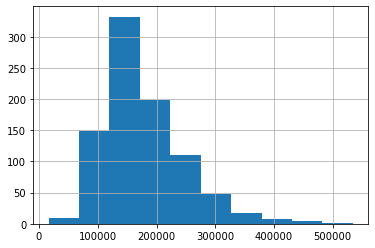

In [158]:
df_test_submit["SalePrice"].hist();

In [159]:
df_test_submit.to_csv("../datasets/submit_ridgereg.csv", index=False)

### LASSO - PREDICT

In [160]:
df_test_lasso = df_test.copy()

In [161]:
df_test_lasso['SalePrice'] = lasso_final.predict(X_test_poly_scaled)

In [162]:
df_test_submit = df_test_lasso[['Id','SalePrice']]

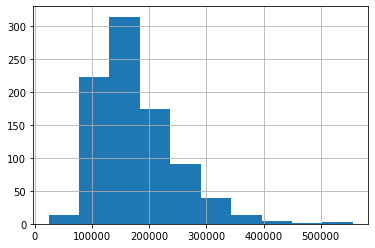

In [163]:
df_test_submit["SalePrice"].hist();

In [164]:
df_test_submit.to_csv("../datasets/submit_lassoreg.csv", index=False)

### ENET - PREDICT

In [165]:
df_test_enet = df_test.copy()

In [166]:
df_test_enet['SalePrice'] = enet_final.predict(X_test_poly_scaled)

In [167]:
df_test_submit = df_test_enet[['Id','SalePrice']]

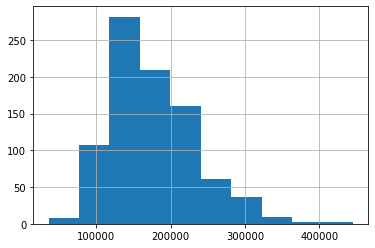

In [168]:
df_test_submit["SalePrice"].hist();

In [169]:
df_test_submit.to_csv("../datasets/submit_enetreg.csv", index=False)

*Files are submitted to Kaggle